In [6]:
# --- 1. IMPORTS & SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             precision_recall_curve, f1_score)

# Visualization styling
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

print("Step 1: Libraries loaded.")

Step 1: Libraries loaded.


Cell 2: Data Loading & Preprocessing

This cell loads the aggregated data, handles missing values, and splits the data. We use Stratified Splitting to maintain the fraud ratio.

In [7]:
# --- 2. DATA LOADING & PREPROCESSING ---

# Load the aggregated provider data
# Ensure 'provider_features_for_modeling.csv' is in your working directory
try:
    df_final = pd.read_csv('provider_features_for_modeling.csv')
    print(f"Step 2: Dataset loaded. Shape: {df_final.shape}")
except FileNotFoundError:
    print("Error: 'provider_features_for_modeling.csv' not found. Please upload the file.")

# A. Target Encoding
# Convert 'Yes'/'No' to 1/0 for binary classification
df_final['PotentialFraud'] = df_final['PotentialFraud'].map({'Yes': 1, 'No': 0})

# B. Missing Value Imputation
# 'AvgLengthOfStay' has NaNs for providers with only outpatient claims (no hospital stay).
# We fill with 0 to preserve this pattern as a meaningful signal.
df_final = df_final.fillna(0)

# C. Feature Selection
# Drop IDs and Target to isolate features
X = df_final.drop(['Provider', 'PotentialFraud'], axis=1)
y = df_final['PotentialFraud']

# D. Stratified Train-Test Split
# We use stratification because fraud is a minority class (~9%).
# Random splitting could result in a test set with no fraud cases.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# E. Scaling
# Standard scaling helps Logistic Regression convergence and standardizes feature influence.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data Split: Train size {X_train.shape[0]}, Test size {X_test.shape[0]}")
print(f"Fraud proportion in Test set: {y_test.mean():.2%}")

Step 2: Dataset loaded. Shape: (5410, 11)
Data Split: Train size 4328, Test size 1082
Fraud proportion in Test set: 9.33%


Cell 3: Algorithm Selection & Cross-Validation

This cell defines the models and performs 5-Fold Cross-Validation to prove model stability.

In [8]:
# --- 3. ALGORITHM SELECTION & CROSS-VALIDATION ---

# We define 3 models as per project requirements:
# 1. Logistic Regression: Baseline, highly interpretable.
# 2. Random Forest: Robust to outliers, handles non-linear data.
# 3. Gradient Boosting: High predictive performance.

# Strategy for Class Imbalance: 'class_weight="balanced"'
# This penalizes the model more for missing a fraud case (False Negative) than for a False Positive.
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# 5-Fold Stratified Cross-Validation
# Ensures results are stable and not just due to a lucky split.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nStep 3: Performing 5-Fold Cross-Validation (F1 Score)...")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    print(f"  {name} Avg F1 Score: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")


Step 3: Performing 5-Fold Cross-Validation (F1 Score)...
  Logistic Regression Avg F1 Score: 0.5553 (+/- 0.0154)
  Random Forest Avg F1 Score: 0.5389 (+/- 0.0363)
  Gradient Boosting Avg F1 Score: 0.5721 (+/- 0.0382)


Cell 4: Final Training & PR Curve

This cell trains the models on the full training set and plots the Precision-Recall curve (the most important metric for imbalance).


Step 4: Final Training & Evaluation on Test Set...

--- Logistic Regression ---
ROC-AUC: 0.9618 | PR-AUC (Avg Precision): 0.7587
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       981
           1       0.42      0.92      0.57       101

    accuracy                           0.87      1082
   macro avg       0.70      0.89      0.75      1082
weighted avg       0.94      0.87      0.89      1082


--- Random Forest ---
ROC-AUC: 0.9468 | PR-AUC (Avg Precision): 0.7203
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       981
           1       0.72      0.55      0.63       101

    accuracy                           0.94      1082
   macro avg       0.84      0.77      0.80      1082
weighted avg       0.93      0.94      0.93      1082


--- Gradient Boosting ---
ROC-AUC: 0.9536 | PR-AUC (Avg Precision): 0.6721
              precision    recall  f1-score   support

           0 

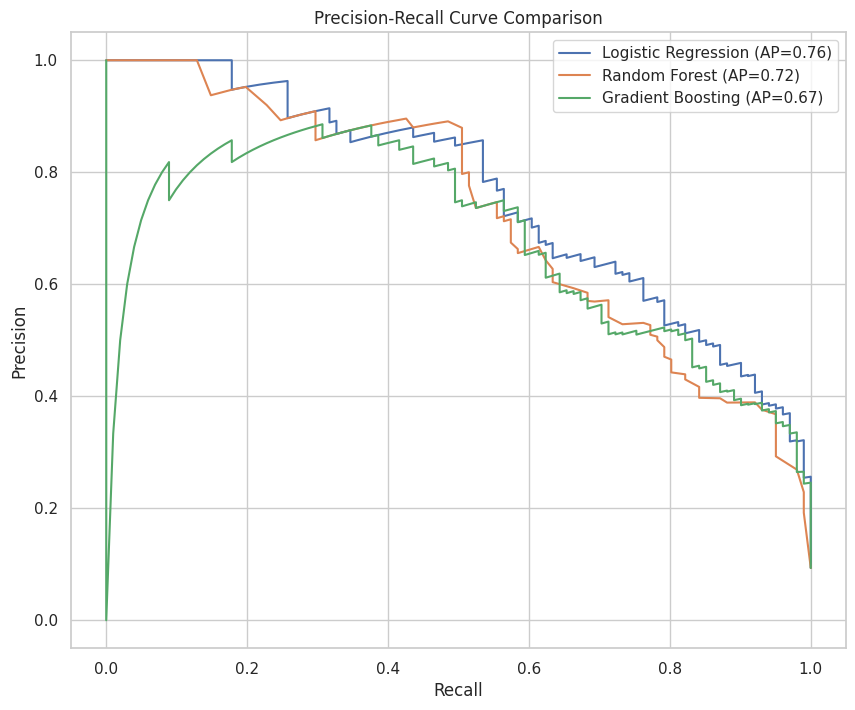

In [9]:
# --- 4. FINAL MODEL TRAINING & EVALUATION ---

results = {}
plt.figure(figsize=(10, 8))

print("\nStep 4: Final Training & Evaluation on Test Set...")
for name, model in models.items():
    # Train on full training set
    model.fit(X_train_scaled, y_train)

    # Predict on Test set
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate Metrics
    roc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)

    results[name] = {'model': model, 'y_pred': y_pred, 'y_prob': y_prob}

    print(f"\n--- {name} ---")
    print(f"ROC-AUC: {roc:.4f} | PR-AUC (Avg Precision): {pr_auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Plot Precision-Recall Curve
    # PR Curves are the gold standard for imbalanced fraud detection.
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name} (AP={pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

Cell 5: Confusion Matrices

Visualizes False Positives vs False Negatives.

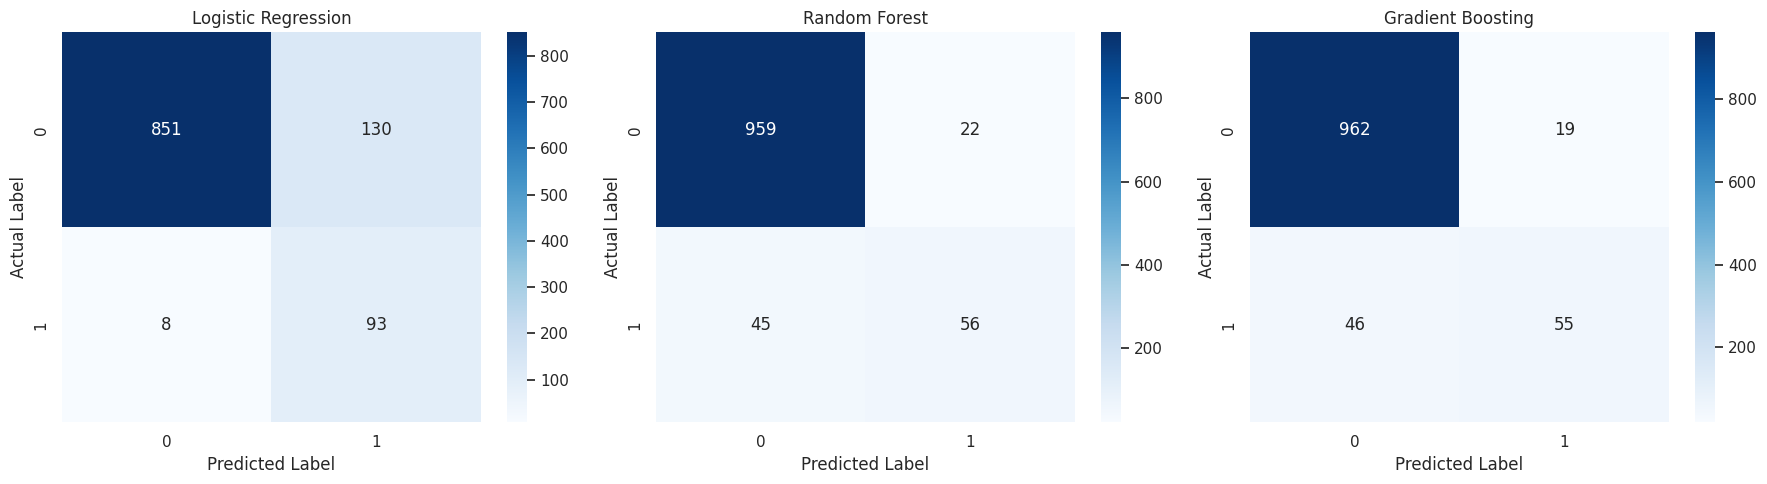

In [10]:
# --- 5. CONFUSION MATRICES ---
# Visualizes False Positives vs False Negatives side-by-side.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (name, info) in enumerate(results.items()):
    cm = confusion_matrix(y_test, info['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('Actual Label')
plt.tight_layout()
plt.show()

Cell 6: Feature Importance

Explains what is driving the Random Forest predictions.

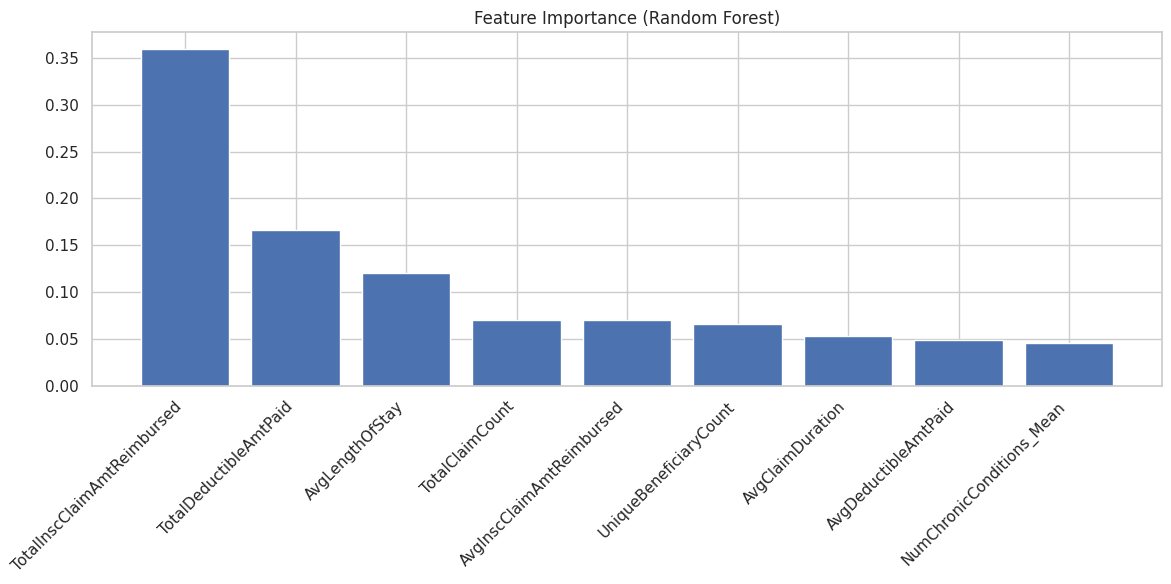

In [11]:
# --- 6. FEATURE IMPORTANCE (Random Forest) ---
# Provides explainability for which behaviors drive fraud flags.
rf_model = results['Random Forest']['model']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45, ha="right")
plt.tight_layout()
plt.show()

Cell 7: Error Analysis (Candidate Extraction)

Extracts specific Provider IDs for your final report case studies.

In [12]:
# --- 7. ERROR ANALYSIS: CANDIDATE EXTRACTION ---
# Extracts specific Provider IDs for the "Case Studies" required in the final report.

print("\nStep 7: Extracting Error Analysis Candidates...")
# Select best model (Random Forest is typically robust for this data)
best_model_name = 'Random Forest'
y_pred_final = results[best_model_name]['y_pred']

# Create analysis dataframe mapped back to original Provider IDs using test indices
test_indices = X_test.index
df_analysis = df_final.loc[test_indices].copy()
df_analysis['PredictedFraud'] = y_pred_final
df_analysis['ActualFraud'] = y_test

# Identify False Positives (Legitimate providers flagged as Fraud)
false_positives = df_analysis[(df_analysis['PredictedFraud'] == 1) & (df_analysis['ActualFraud'] == 0)]

# Identify False Negatives (Fraudulent providers missed by model)
false_negatives = df_analysis[(df_analysis['PredictedFraud'] == 0) & (df_analysis['ActualFraud'] == 1)]

print(f"Total False Positives found: {len(false_positives)}")
print(f"Total False Negatives found: {len(false_negatives)}")

print("\n--- Top 3 False Positive Candidates (For Case Study) ---")
print(false_positives.head(3)['Provider'].values)

print("\n--- Top 3 False Negative Candidates (For Case Study) ---")
print(false_negatives.head(3)['Provider'].values)

# Save candidates to CSV for report writing
false_positives.head(5).to_csv('false_positives_case_study.csv')
false_negatives.head(5).to_csv('false_negatives_case_study.csv')
print("\nCandidate lists saved to CSV.")


Step 7: Extracting Error Analysis Candidates...
Total False Positives found: 22
Total False Negatives found: 45

--- Top 3 False Positive Candidates (For Case Study) ---
['PRV53872' 'PRV52842' 'PRV55443']

--- Top 3 False Negative Candidates (For Case Study) ---
['PRV56591' 'PRV53787' 'PRV56566']

Candidate lists saved to CSV.
